In [1]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yellowbrick
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

In [76]:
# Cargar los datos
df = pd.read_csv('hotusa_cancellations.csv')

In [78]:
# Eliminar columnas innecesarias
df.drop(columns=['Unnamed: 0'], inplace=True)
df.drop(columns=['Company'], inplace=True)
df.drop(columns=['HotelId'], inplace=True)

# Convertir columnas de fecha
df['ReservationStatusDate'] = pd.to_datetime(df['ReservationStatusDate'])
df['ArrivalDate'] = pd.to_datetime(df['ArrivalDate'])

# Manejar valores nulos
df['Country'].fillna('Unknown', inplace=True)  # Asumiendo que 'Unknown' es una categoría adecuada

# Mostras las primeras filas
print(df.head())

  ReservationStatusDate ArrivalDate  LeadTime  StaysInWeekendNights  \
0            2016-12-15  2017-02-10       238                     0   
1            2015-12-07  2016-05-27       174                     2   
2            2015-08-24  2015-12-20       260                     4   
3            2016-01-05  2016-04-12       168                     0   
4            2015-11-11  2015-11-11         1                     0   

   StaysInWeekNights  Adults  Children CustomerType     ADR       Meal  \
0                  2       2         0    Transient   54.00  HB          
1                  5       2         1    Transient  108.02  BB          
2                  9       1         0    Transient   47.54  BB          
3                  2       2         0    Transient   86.00  HB          
4                  1       1         0    Transient   35.00  BB          

  Country  ReservedRoomType  IsRepeatedGuest  IsCanceled  
0     PRT  A                           False        True  
1     PRT 

/tmp/ipykernel_25722/304138749.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Country'].fillna('Unknown', inplace=True)  # Asumiendo que 'Unknown' es una categoría adecuada


In [79]:
# Preparación de los datos
## División de los datos en características y etiquetas
X = df.drop('IsCanceled', axis=1)
y = df['IsCanceled']

## Codificación y escalado de variables
numeric_features = ['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children', 'ADR']
categorical_features = ['CustomerType', 'Meal', 'Country', 'ReservedRoomType', 'IsRepeatedGuest']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputación para manejar posibles valores faltantes
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Manejo de valores nulos en categóricas
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [80]:
# Construcción del modelo
## Pipeline completo con preprocesador y modelo
first_model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])

In [81]:
## División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del modelo
first_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LeadTime',
                                                   'StaysInWeekendNights',
                                                   'StaysInWeekNights',
                                                   'Adults', 'Children',
                                                   'ADR']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['CustomerType', 'Meal',
                                                   'Country',
                                                   'ReservedRoomType',
                                                   'IsRepeatedGuest'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

              precision    recall  f1-score   support

       False       0.92      0.97      0.95      5796
        True       0.74      0.47      0.58       942

    accuracy                           0.90      6738
   macro avg       0.83      0.72      0.76      6738
weighted avg       0.89      0.90      0.89      6738

Accuracy: 0.9032353814188187
AUC-ROC: 0.8786469070843207


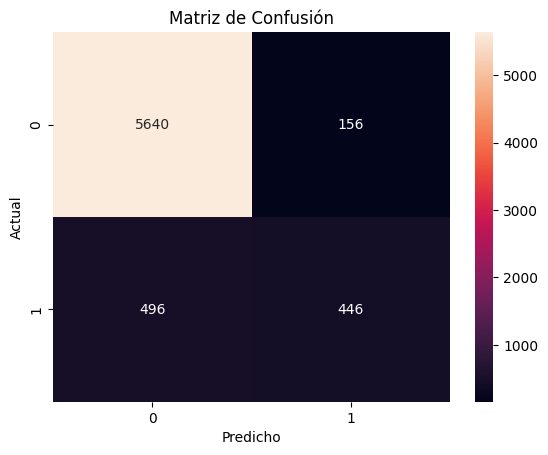

In [82]:
# Evaluación inicial del modelo
## Predicciones
y_pred = first_model.predict(X_test)

## Métricas de rendimiento
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, first_model.predict_proba(X_test)[:, 1]))

## Matriz de confusión
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title('Matriz de Confusión')
plt.ylabel('Actual')
plt.xlabel('Predicho')
plt.show()

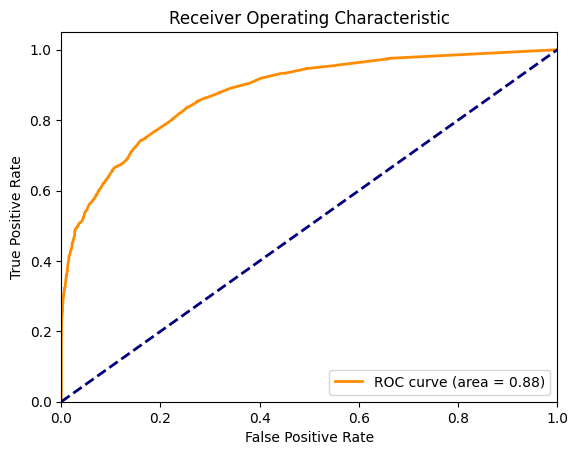

In [83]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, first_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

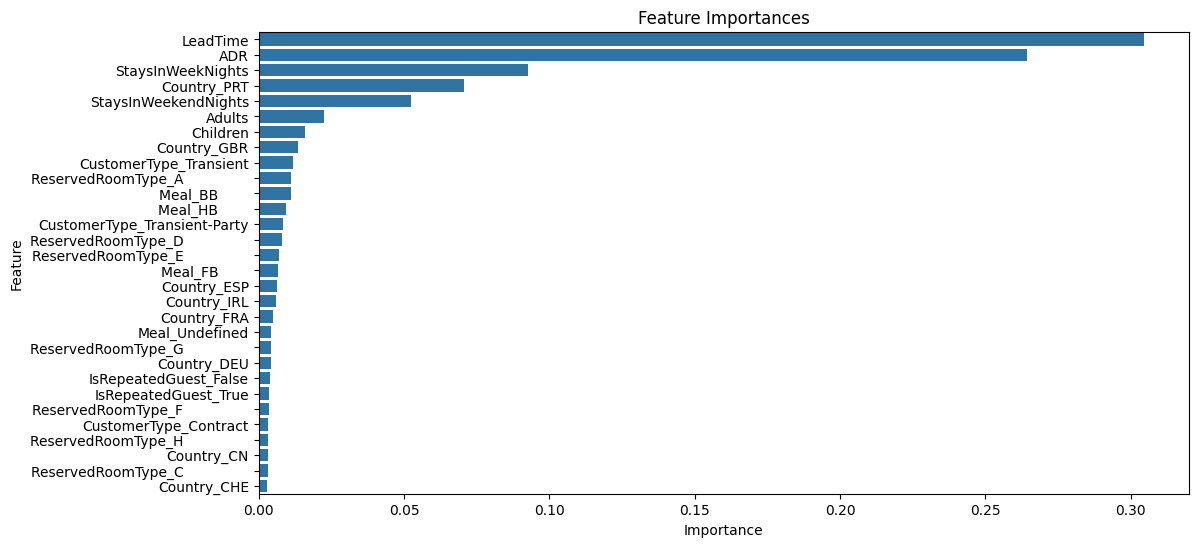

In [84]:
# Obtener importancias de las características
feature_names = numeric_features + list(first_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))
importances = first_model.named_steps['classifier'].feature_importances_

# Crear un DataFrame para visualizar las importancias
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Visualización de las importancias de las características
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(30))
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

<div class="alert alert-danger">
<b>Cuidado:</b> Al lanzar la siguiente celda se llevará a cabo un proceso que puede llevar varios minutos.
</div>


In [85]:
# Ahora voy a intentar mejorar los resultados del modelo mediante la optimización de hiperparámetros

from sklearn.model_selection import GridSearchCV

# Definir parámetros para la búsqueda en cuadrícula
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(first_model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Evaluar el mejor modelo
best_model.fit(X_train, y_train)
best_y_pred = best_model.predict(X_test)

print(classification_report(y_test, best_y_pred))
print("Accuracy:", accuracy_score(y_test, best_y_pred))
print("AUC-ROC:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))


/home/ruben/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/ruben/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
221 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ruben/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ruben/.local/lib/python3.10

              precision    recall  f1-score   support

       False       0.90      0.99      0.94      5796
        True       0.84      0.34      0.48       942

    accuracy                           0.90      6738
   macro avg       0.87      0.67      0.71      6738
weighted avg       0.89      0.90      0.88      6738

Accuracy: 0.8986346096764618
AUC-ROC: 0.8845103658867159


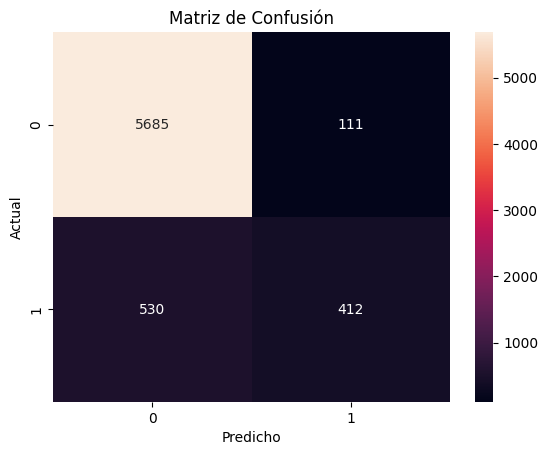

In [ ]:
# Matriz de confusión

conf_mat = confusion_matrix(y_test, best_y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title('Matriz de Confusión')
plt.ylabel('Actual')
plt.xlabel('Predicho')
plt.show()